# Algorithmic Trading Model with Dual Moving Average Crossover Using Python Take 3
### David Lowe
### April 6, 2020

Code Credit: Adapted from code samples used in O'Reilly Media's Learning Path: Hands-On Algorithmic Trading with Python by Deepak Kanungo. [https://learning.oreilly.com/learning-paths/learning-path-hands-on/9781492082613/]

SUMMARY: The purpose of this project is to construct an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model uses the 20-day and 50-day moving averages to generate trading signals. We apply the analysis on the MSFT stock for the three years of 2017-01-01 thru 2019-12-31.

In iteration Take1, we constructed the code modules to cover the tasks of downloading the daily price information for a stock symbol.

In iteration Take2, we developed a trading model by constructing the coding segments to process the stock pricing data and generate trading signals.

In this Take3 iteration, we will use the trading signals to "backtest" and evaluate the trading model by comparing the strategy with a long-only approach.

ANALYSIS: The long-only approach achieved an accumulated return of 2.3869%. In the meantime, the SMA crossover strategy returned 2.0586%.

CONCLUSION: For this time period, the SMA crossover strategy did not exceed the more straightforward long-only approach, so we should consider different models for this stock.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Various sources as illustrated below.

Dataset Reference: Various sources as documented below.

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Fit Models
4. Backtest Models
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
# Create the random seed number for reproducible results
seedNum = 888

In [2]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import json
import requests
from email.message import EmailMessage
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime, timedelta

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

In [5]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [6]:
start_date = datetime(2017, 1, 1)
print("Starting date:", start_date)
# end_date = datetime.now()
end_date = datetime(2019, 12, 31)
print("Ending date:", end_date)
stock_symbol = 'MSFT'

Starting date: 2017-01-01 00:00:00
Ending date: 2019-12-31 00:00:00


In [7]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [8]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Federal Reserve Economic Data (FRED)

In [9]:
fred_data = 'DGS10'
fred_series = pdr.DataReader(fred_data, 'fred', start_date, end_date)
print(len(fred_series), 'data points retrieved from the API call.')

782 data points retrieved from the API call.


In [10]:
fred_series.head()

,DGS10
DATE,
2017-01-02,NaN
2017-01-03,2.45
2017-01-04,2.46
2017-01-05,2.37
2017-01-06,2.42


In [11]:
fred_series.tail()

,DGS10
DATE,
2019-12-25,NaN
2019-12-26,1.90
2019-12-27,1.88
2019-12-30,1.90
2019-12-31,1.92


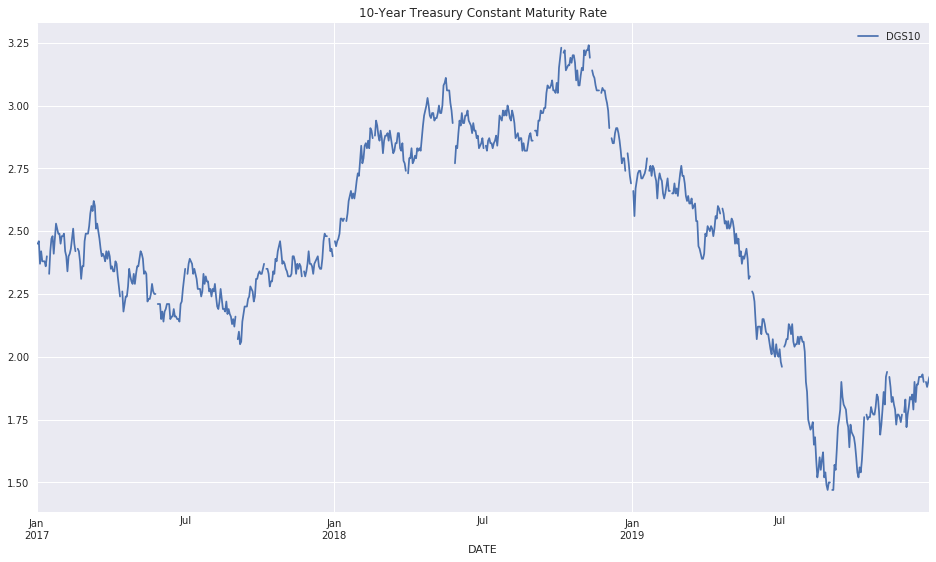

In [12]:
title_string = '10-Year Treasury Constant Maturity Rate'
fred_series.plot(figsize=(16,9), title=title_string)
plt.show()

### 2.b) Alpha Vantage

In [13]:
# Check and see whether the API key is available
alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
if (alphavantage_key==None): sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")

alphavantage_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=%s&outputsize=full&apikey=%s" % (stock_symbol, alphavantage_key)

In [14]:
response = requests.get(alphavantage_url)
alpha_dict = json.loads(response.text)
print(len(alpha_dict['Time Series (Daily)']), 'data points retrieved from the API call.')
if (verbose): print(alpha_dict)

5033 data points retrieved from the API call.


In [15]:
stock_alpha = pd.DataFrame(alpha_dict['Time Series (Daily)']).T
stock_alpha.index = pd.to_datetime(stock_alpha.index)
stock_alpha = stock_alpha.sort_index(ascending = True)
stock_alpha.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split_coef']
stock_alpha = stock_alpha.astype(float)
stock_alpha.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2000-03-24 to 2020-03-26
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        5033 non-null   float64
 1   high        5033 non-null   float64
 2   low         5033 non-null   float64
 3   close       5033 non-null   float64
 4   adj_close   5033 non-null   float64
 5   volume      5033 non-null   float64
 6   dividend    5033 non-null   float64
 7   split_coef  5033 non-null   float64
dtypes: float64(8)
memory usage: 353.9 KB


In [16]:
stock_alpha.head()

,open,high,low,close,adj_close,volume,dividend,split_coef
2000-03-24,112.62,115.00,109.56,111.69,35.9087,56098400.0,0.0,1.0
2000-03-27,107.77,108.25,103.94,104.06,33.4556,55717000.0,0.0,1.0
2000-03-28,103.62,107.44,102.37,104.31,33.5360,40557200.0,0.0,1.0
2000-03-29,105.19,108.94,105.12,107.19,34.4619,32181900.0,0.0,1.0
2000-03-30,106.19,108.62,102.50,103.37,33.2338,32089200.0,0.0,1.0


In [17]:
stock_alpha.tail()

,open,high,low,close,adj_close,volume,dividend,split_coef
2020-03-20,146.00,147.10,135.86,137.35,137.35,84866215.0,0.0,1.0
2020-03-23,137.01,140.57,132.52,135.98,135.98,78975176.0,0.0,1.0
2020-03-24,143.75,149.60,141.27,148.34,148.34,82516727.0,0.0,1.0
2020-03-25,148.91,154.33,144.44,146.92,146.92,74091383.0,0.0,1.0
2020-03-26,148.40,154.24,148.37,153.00,153.00,38359540.0,0.0,1.0


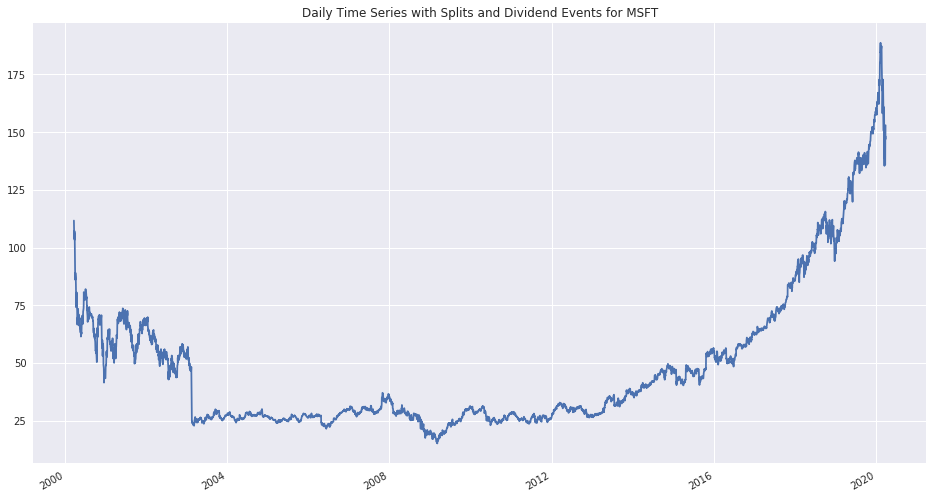

In [18]:
title_string = alpha_dict['Meta Data']['1. Information'] + ' for ' + alpha_dict['Meta Data']['2. Symbol']
stock_alpha['close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.c) Yahoo Finance

In [19]:
import yfinance as yf
yf.pdr_override()
stock_yahoo = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
print(len(stock_yahoo), 'data points retrieved from the API call.')

[*********************100%***********************]  1 of 1 completed
753 data points retrieved from the API call.


In [20]:
stock_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2017-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       753 non-null    float64
 1   High       753 non-null    float64
 2   Low        753 non-null    float64
 3   Close      753 non-null    float64
 4   Adj Close  753 non-null    float64
 5   Volume     753 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [21]:
stock_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,59.133289,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,58.868710,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,58.868710,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,59.378971,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,59.189987,20382700


In [22]:
stock_yahoo.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,158.119995,158.119995,157.270004,157.410004,156.981232,17718200
2019-12-24,157.479996,157.710007,157.119995,157.380005,156.951309,8989200
2019-12-26,157.559998,158.729996,157.399994,158.669998,158.237793,14520600
2019-12-27,159.449997,159.550003,158.220001,158.960007,158.527008,18412800
2019-12-30,158.990005,159.020004,156.729996,157.589996,157.160736,16348400


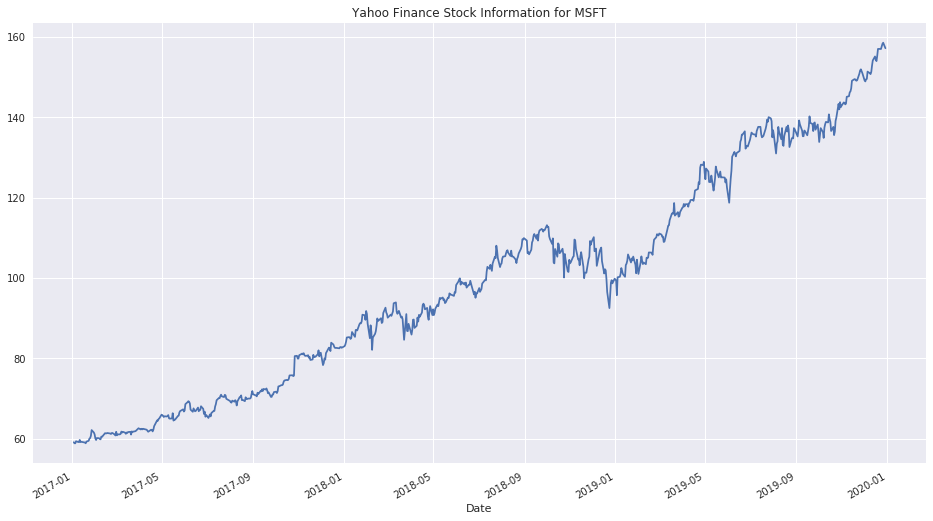

In [23]:
title_string = 'Yahoo Finance Stock Information for ' + stock_symbol
stock_yahoo['Adj Close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.d) Quandl

In [24]:
# import quandl

# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if (quandl_key==None): sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

quandl_url = "https://www.quandl.com/api/v3/datasets/EOD/%s.json?api_key=%s" % (stock_symbol, quandl_key)

In [25]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
print(len(quandl_dict['dataset']['data']), 'data points retrieved from the API call.')
if (verbose): print(quandl_dict)

1090 data points retrieved from the API call.


In [26]:
stock_quandl = pd.DataFrame(quandl_dict['dataset']['data'])
stock_quandl.columns = quandl_dict['dataset']['column_names']
stock_quandl.set_index('Date', inplace=True)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090 entries, 2013-09-03 to 2017-12-28
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1090 non-null   float64
 1   High        1090 non-null   float64
 2   Low         1090 non-null   float64
 3   Close       1090 non-null   float64
 4   Volume      1090 non-null   float64
 5   Dividend    1090 non-null   float64
 6   Split       1090 non-null   float64
 7   Adj_Open    1090 non-null   float64
 8   Adj_High    1090 non-null   float64
 9   Adj_Low     1090 non-null   float64
 10  Adj_Close   1090 non-null   float64
 11  Adj_Volume  1090 non-null   float64
dtypes: float64(12)
memory usage: 110.7+ KB


In [27]:
stock_quandl.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.559502,27.837267,27.160215,27.672344,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.247017,27.316458,27.003972,27.077754,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.995292,27.290417,26.865090,27.112474,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.177575,27.247017,27.021333,27.040429,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.100148,27.594223,27.082094,27.477041,49628500.0


In [28]:
stock_quandl.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,83.403000,83.451462,82.772995,82.869919,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,82.772995,82.995920,82.307760,82.879611,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,82.685763,82.903454,82.414376,82.772995,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,83.015304,83.335153,82.593686,83.073459,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,83.257614,83.286691,82.918381,83.083151,10594344.0


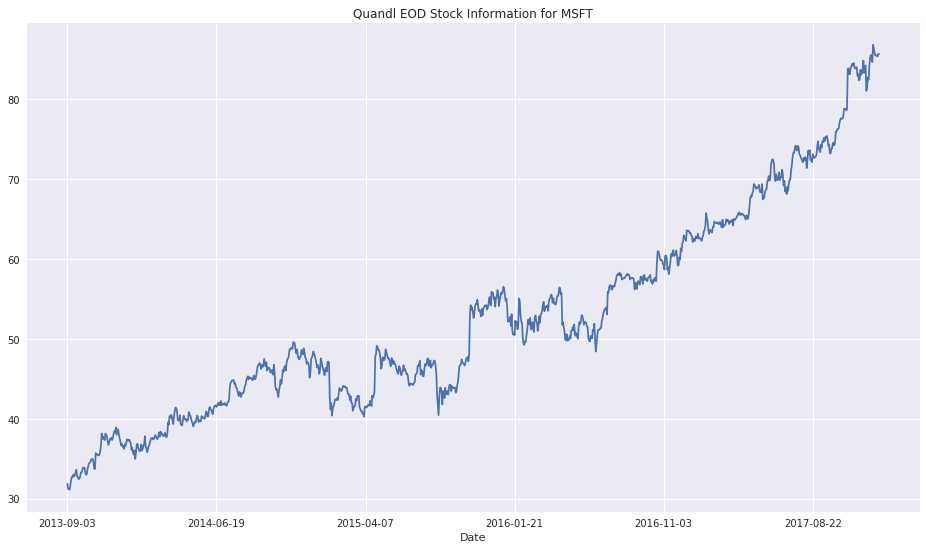

In [29]:
title_string = 'Quandl EOD Stock Information for ' + quandl_dict['dataset']['dataset_code']
stock_quandl['Close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.e) IEX Cloud

In [30]:
# Check and see whether the API key is available
# iexcloud_key = os.environ.get('IEXCLOUD_API')
iexcloud_key = "Tsk_7be365b9ca0a4e0eaea2bd427afab760"
if (iexcloud_key==None): sys.exit("API key for IEX Cloud not available. Script Processing Aborted!!!")

iexcloud_url = "https://sandbox.iexapis.com/stable/stock/%s/chart/5y?token=%s" % (stock_symbol, iexcloud_key)

In [31]:
response = requests.get(iexcloud_url)
iex_dict = json.loads(response.text)
print(len(iex_dict), 'data points retrieved from the API call.')
if (verbose): print(iex_dict)

1259 data points retrieved from the API call.


In [32]:
stock_iexcloud = pd.DataFrame(iex_dict)
stock_iexcloud.set_index('date', inplace=True)
stock_iexcloud = stock_iexcloud.sort_index(ascending = True)
stock_iexcloud.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2015-03-26 to 2020-03-25
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uClose          1259 non-null   float64
 1   uOpen           1259 non-null   float64
 2   uHigh           1259 non-null   float64
 3   uLow            1259 non-null   float64
 4   uVolume         1259 non-null   int64  
 5   close           1259 non-null   float64
 6   open            1259 non-null   float64
 7   high            1259 non-null   float64
 8   low             1259 non-null   float64
 9   volume          1259 non-null   int64  
 10  change          1259 non-null   float64
 11  changePercent   1259 non-null   float64
 12  label           1259 non-null   object 
 13  changeOverTime  1259 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 147.5+ KB


In [33]:
stock_iexcloud.head()

,uClose,uOpen,uHigh,uLow,uVolume,close,open,high,low,volume,change,changePercent,label,changeOverTime
date,,,,,,,,,,,,,,
2015-03-26,42.78,41.90,42.01,41.65,39336141,41.84,41.65,43.02,40.99,38563113,0.000,0.0000,"Mar 26, 15",0.000000
2015-03-27,42.17,42.04,43.29,42.13,34767366,41.94,43.17,41.44,40.85,35826475,-0.240,-0.5875,"Mar 27, 15",-0.005825
2015-03-30,42.49,42.30,43.15,42.09,36392926,41.94,42.30,41.93,42.56,36038732,-0.010,-0.0251,"Mar 30, 15",-0.006364
2015-03-31,40.89,41.52,41.86,42.32,34900707,41.14,41.89,42.16,40.79,35148446,-0.315,-0.7556,"Mar 31, 15",-0.013780
2015-04-01,40.79,41.50,41.40,41.37,38094047,42.55,40.90,41.86,40.59,37202264,0.066,0.1623,"Apr 1, 15",-0.012010


In [34]:
stock_iexcloud.tail()

,uClose,uOpen,uHigh,uLow,uVolume,close,open,high,low,volume,change,changePercent,label,changeOverTime
date,,,,,,,,,,,,,,
2020-03-19,147.23,142.88,152.72,139.00,87950572,143.44,143.53,151.57,142.00,86761845,2.41,1.7244,"Mar 19, 20",2.486554
2020-03-20,141.97,153.00,154.40,136.15,85804326,144.02,149.00,153.00,139.15,85285272,-5.52,-3.8144,"Mar 20, 20",2.418247
2020-03-23,140.08,140.99,147.26,132.94,82008968,141.61,141.17,145.03,135.81,81416773,-1.43,-1.0266,"Mar 23, 20",2.372068
2020-03-24,153.13,146.05,151.80,144.65,82678436,154.14,146.81,154.00,147.32,83811648,12.41,9.3567,"Mar 24, 20",2.661119
2020-03-25,153.39,152.64,155.33,148.19,77105437,152.48,150.21,156.69,150.57,77620906,-1.43,-0.9880,"Mar 25, 20",2.658385


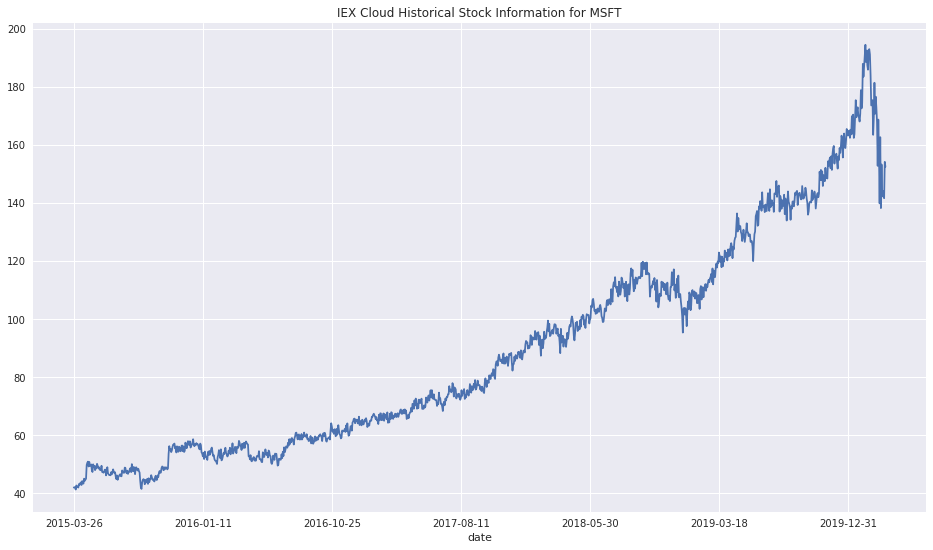

In [35]:
title_string = 'IEX Cloud Historical Stock Information for ' + stock_symbol
stock_iexcloud['close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.f) Electronic Data Gathering, Analysis, and Retrieval system (EDGAR)

In [36]:
import edgar
edgar_filing = edgar.Company("MICROSOFT CORP", "0000789019")
tree = edgar_filing.get_all_filings(filing_type = "10-K")
docs = edgar_filing.get_documents(tree, no_of_documents=5)
print(len(docs), "documents retrieved from EDGAR.")

5 documents retrieved from EDGAR.


In [37]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Fit Models

In [38]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Fit Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set up the Dataframe for the Trading Model

In [39]:
# Select the data source and pricing columns to use for modeling
trading_model = stock_alpha.loc[start_date:end_date, ['adj_close']]
# trading_model = stock_yahoo
# trading_model = stock_quandl
# trading_model = stock_iexcloud

# Set up the standard column name for modeling
trading_model['price'] = trading_model['adj_close']
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj_close  754 non-null    float64
 1   price      754 non-null    float64
dtypes: float64(2)
memory usage: 17.7 KB


In [40]:
trading_model.head()

,adj_close,price
2017-01-03,59.1329,59.1329
2017-01-04,58.8684,58.8684
2017-01-05,58.8684,58.8684
2017-01-06,59.3786,59.3786
2017-01-09,59.1896,59.1896


In [41]:
trading_model.tail()

,adj_close,price
2019-12-24,156.9526,156.9526
2019-12-26,158.2391,158.2391
2019-12-27,158.5283,158.5283
2019-12-30,157.1620,157.1620
2019-12-31,157.2717,157.2717


In [42]:
# Set up the modeling strategy of using moving average lines
SMA1 = 20
SMA2 = 50
trading_model['SMA1'] = trading_model['price'].rolling(SMA1).mean()
trading_model['SMA2'] = trading_model['price'].rolling(SMA2).mean()

# Drop the initial rows with the NaN value
trading_model.dropna(inplace=True)
trading_model.head()

,adj_close,price,SMA1,SMA2
2017-03-15,61.5530,61.5530,61.332410,60.485568
2017-03-16,61.4484,61.4484,61.337640,60.531878
2017-03-17,61.6670,61.6670,61.354275,60.587850
2017-03-20,61.7241,61.7241,61.369010,60.644964
2017-03-21,61.0396,61.0396,61.355700,60.678184


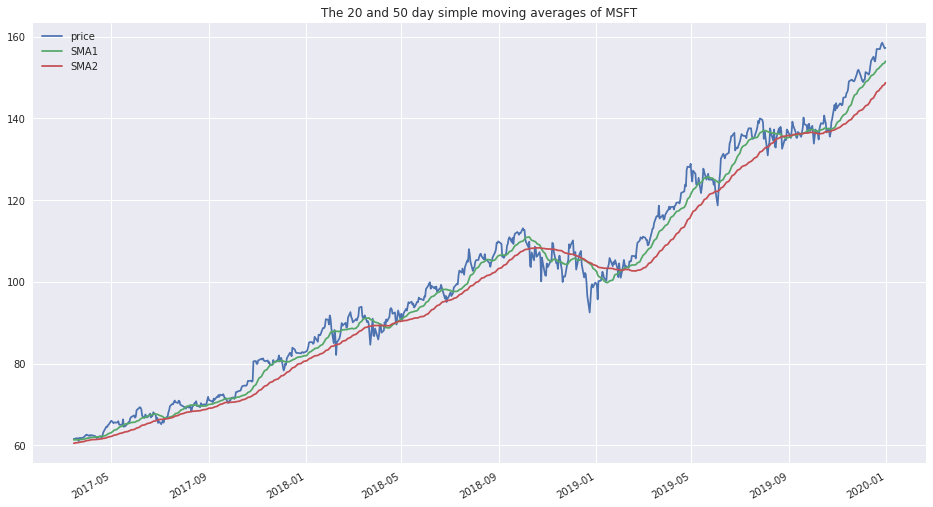

In [43]:
begin_plot = start_date
end_plot = end_date

# Customize the plotting period if requied
# plot_length = 360
# begin_plot = end_plot - timedelta(days=plot_length)

title_string = 'The 20 and 50 day simple moving averages of ' + stock_symbol
trading_model.loc[begin_plot:end_plot, ['price','SMA1','SMA2']].plot(figsize=(16,9), title=title_string)
plt.show()

### 3.b) Set up the Analysis for the Trading Signals

In a dual moving average crossover strategy, we compare a short-term (e.g. 20 days) simple moving average (SMA) with a longer-term moving average (e.g. 50 days) to detect price momentum and generate the crossover signal.

The value of the signal is +1 when the 20-day SMA is above the the 50-day SMA and -1 when the opposite occurs.

In [44]:
# Generate the trading signals (1 : Buying, -1 : Selling)
trading_model['price_change'] = trading_model['price'].diff()
trading_model['sma_change'] = trading_model['SMA1'] - trading_model['SMA2']
trading_model['signal']= np.where(trading_model['sma_change'] > 0, 1, -1)
trading_model.head(10)

,adj_close,price,SMA1,SMA2,price_change,sma_change,signal
2017-03-15,61.5530,61.5530,61.332410,60.485568,NaN,0.846842,1
2017-03-16,61.4484,61.4484,61.337640,60.531878,-0.1046,0.805762,1
2017-03-17,61.6670,61.6670,61.354275,60.587850,0.2186,0.766425,1
2017-03-20,61.7241,61.7241,61.369010,60.644964,0.0571,0.724046,1
2017-03-21,61.0396,61.0396,61.355700,60.678184,-0.6845,0.677516,1
2017-03-22,61.8191,61.8191,61.387545,60.730774,0.7795,0.656771,1
2017-03-23,61.6670,61.6670,61.399425,60.780700,-0.1521,0.618725,1
2017-03-24,61.7716,61.7716,61.416535,60.821946,0.1046,0.594589,1
2017-03-27,61.8857,61.8857,61.457890,60.876434,0.1141,0.581456,1
2017-03-28,62.0663,62.0663,61.520155,60.932834,0.1806,0.587321,1


In [45]:
trading_model.tail(10)

,adj_close,price,SMA1,SMA2,price_change,sma_change,signal
2019-12-17,154.2699,154.2699,150.993765,145.373754,-0.8377,5.620011,1
2019-12-18,153.9508,153.9508,151.217700,145.755932,-0.3191,5.461768,1
2019-12-19,155.2871,155.2871,151.521370,146.113750,1.3363,5.407620,1
2019-12-20,156.9825,156.9825,151.916795,146.488380,1.6954,5.428415,1
2019-12-23,156.9825,156.9825,152.306735,146.851482,0.0000,5.455253,1
2019-12-24,156.9526,156.9526,152.613400,147.216570,-0.0299,5.396830,1
2019-12-26,158.2391,158.2391,152.944500,147.567134,1.2865,5.377366,1
2019-12-27,158.5283,158.5283,153.275600,147.946640,0.2892,5.328960,1
2019-12-30,157.1620,157.1620,153.585255,148.313132,-1.3663,5.272123,1
2019-12-31,157.2717,157.2717,153.991645,148.727140,0.1097,5.264505,1


In [46]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Fit Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Backtest and Evaluate Models

In [47]:
if notifyStatus: email_notify("Task 4. Backtest and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

We create a new 'position' column to indicate long vs. flat/short positions. When the dual moving average crossover signal is positive, the strategy goes long (buys) the stock. When the opposite occurs, we can either go short (borrow and sell the stock) or go flat (sell the stock bought earlier). A position value of -1 signifies a short position while 0 indicates a flat position.

A new 'returns' column is created for calculating the continuously compounded daily return of the stock using the log() method. To calculate the continuously compounded daily return, we take the natural logarithm of the simple gross daily return.

In [48]:
trading_model['position'] = np.where(trading_model['SMA1'] > trading_model['SMA2'], 1, 0)
trading_model['returns'] = np.log(trading_model['price']/trading_model['price'].shift(1))
trading_model['strategy'] = trading_model['position'].shift(1) * trading_model['returns']
trading_model.dropna(inplace=True)
trading_model.head(10)

,adj_close,price,SMA1,SMA2,price_change,sma_change,signal,position,returns,strategy
2017-03-16,61.4484,61.4484,61.337640,60.531878,-0.1046,0.805762,1,1,-0.001701,-0.001701
2017-03-17,61.6670,61.6670,61.354275,60.587850,0.2186,0.766425,1,1,0.003551,0.003551
2017-03-20,61.7241,61.7241,61.369010,60.644964,0.0571,0.724046,1,1,0.000926,0.000926
2017-03-21,61.0396,61.0396,61.355700,60.678184,-0.6845,0.677516,1,1,-0.011152,-0.011152
2017-03-22,61.8191,61.8191,61.387545,60.730774,0.7795,0.656771,1,1,0.012690,0.012690
2017-03-23,61.6670,61.6670,61.399425,60.780700,-0.1521,0.618725,1,1,-0.002463,-0.002463
2017-03-24,61.7716,61.7716,61.416535,60.821946,0.1046,0.594589,1,1,0.001695,0.001695
2017-03-27,61.8857,61.8857,61.457890,60.876434,0.1141,0.581456,1,1,0.001845,0.001845
2017-03-28,62.0663,62.0663,61.520155,60.932834,0.1806,0.587321,1,1,0.002914,0.002914
2017-03-29,62.2374,62.2374,61.545345,60.995868,0.1711,0.549477,1,1,0.002753,0.002753


In [49]:
trading_model.tail(10)

,adj_close,price,SMA1,SMA2,price_change,sma_change,signal,position,returns,strategy
2019-12-17,154.2699,154.2699,150.993765,145.373754,-0.8377,5.620011,1,1,-0.005415,-0.005415
2019-12-18,153.9508,153.9508,151.217700,145.755932,-0.3191,5.461768,1,1,-0.002071,-0.002071
2019-12-19,155.2871,155.2871,151.521370,146.113750,1.3363,5.407620,1,1,0.008643,0.008643
2019-12-20,156.9825,156.9825,151.916795,146.488380,1.6954,5.428415,1,1,0.010859,0.010859
2019-12-23,156.9825,156.9825,152.306735,146.851482,0.0000,5.455253,1,1,0.000000,0.000000
2019-12-24,156.9526,156.9526,152.613400,147.216570,-0.0299,5.396830,1,1,-0.000190,-0.000190
2019-12-26,158.2391,158.2391,152.944500,147.567134,1.2865,5.377366,1,1,0.008163,0.008163
2019-12-27,158.5283,158.5283,153.275600,147.946640,0.2892,5.328960,1,1,0.001826,0.001826
2019-12-30,157.1620,157.1620,153.585255,148.313132,-1.3663,5.272123,1,1,-0.008656,-0.008656
2019-12-31,157.2717,157.2717,153.991645,148.727140,0.1097,5.264505,1,1,0.000698,0.000698


In [50]:
trading_model.sample(n=20, random_state=seedNum)

,adj_close,price,SMA1,SMA2,price_change,sma_change,signal,position,returns,strategy
2018-11-26,104.6254,104.6254,104.295530,106.959802,3.3411,-2.664272,-1,0,0.032455,0.000000
2017-06-26,67.4243,67.4243,67.645115,65.980836,-0.6501,1.664279,1,1,-0.009596,-0.009596
2019-11-06,143.1807,143.1807,140.234550,138.209538,-0.3976,2.025012,1,1,-0.002773,-0.002773
2017-07-31,69.4987,69.4987,68.839595,67.778572,-0.3251,1.061023,1,1,-0.004667,-0.004667
2017-04-12,62.0093,62.0093,62.049665,61.420940,-0.2376,0.628725,1,1,-0.003824,-0.003824
2018-10-29,101.6055,101.6055,106.919120,108.127034,-3.0428,-1.207914,-1,0,-0.029508,-0.000000
2019-11-15,149.0546,149.0546,142.785135,139.489274,1.8983,3.295861,1,1,0.012817,0.012817
2018-05-29,95.5191,95.5191,94.108235,91.536620,-0.3411,2.571615,1,1,-0.003565,-0.003565
2019-03-18,116.0290,116.0290,110.608405,106.252096,1.6382,4.356309,1,1,0.014220,0.014220
2018-11-28,109.1948,109.1948,104.864780,106.839784,3.9110,-1.975004,-1,0,0.036474,0.000000


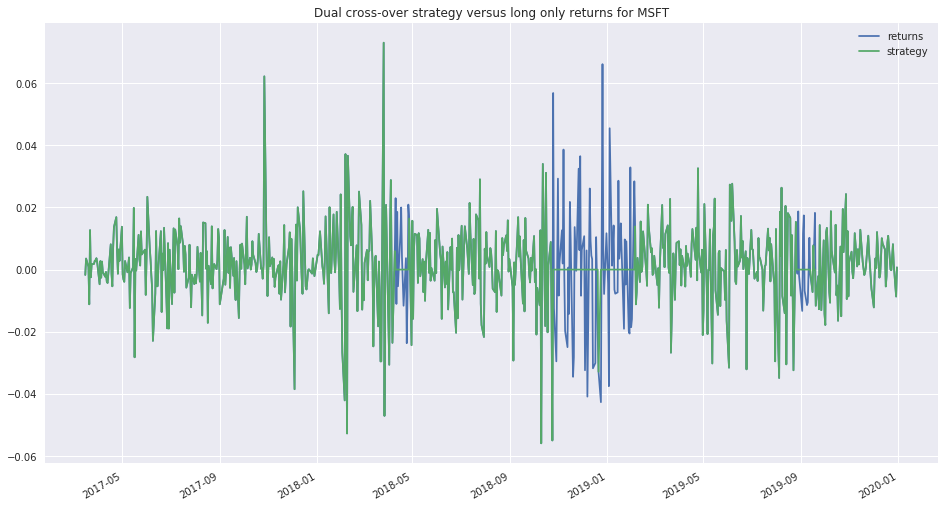

In [51]:
title_string = 'Dual cross-over strategy versus long only returns for ' + stock_symbol
trading_model[['returns', 'strategy']].plot(figsize=(16,9), title=title_string)
plt.show()

In [52]:
if notifyStatus: email_notify("Task 4. Backtest and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [53]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

We compare the performance of the dual moving average strategy with a long only strategy to see if we are able to take advantage of the trading signals.

We use the exponential function to convert the log returns back into the simple gross returns of both types of strategies.

In [54]:
np.exp(trading_model[['returns', 'strategy']].sum())

returns     2.555061
strategy    2.203634
dtype: float64

In [55]:
trading_model[['returns', 'strategy']].describe()

,returns,strategy
count,704.000000,704.000000
mean,0.001332,0.001122
std,0.013974,0.011826
min,-0.055870,-0.055870
25%,-0.004900,-0.002886
50%,0.001457,0.000000
75%,0.008611,0.006818
max,0.072977,0.072977


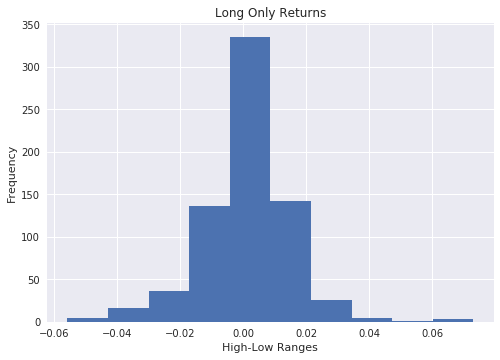

count    704.000000
mean       0.001332
std        0.013974
min       -0.055870
25%       -0.004900
50%        0.001457
75%        0.008611
max        0.072977
Name: returns, dtype: float64


In [56]:
plt.hist(trading_model['returns'])
plt.title('Long Only Returns')
plt.xlabel('High-Low Ranges')
plt.ylabel('Frequency')
plt.show()
print(trading_model['returns'].describe());

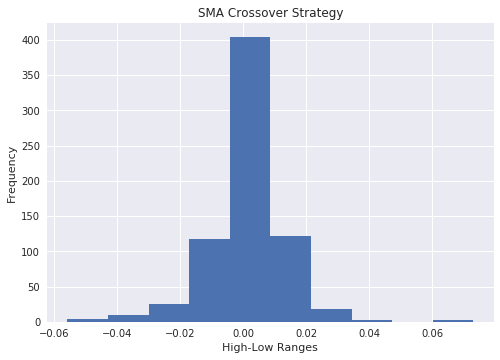

count    704.000000
mean       0.001122
std        0.011826
min       -0.055870
25%       -0.002886
50%        0.000000
75%        0.006818
max        0.072977
Name: strategy, dtype: float64


In [57]:
plt.hist(trading_model['strategy'])
plt.title('SMA Crossover Strategy')
plt.xlabel('High-Low Ranges')
plt.ylabel('Frequency')
plt.show()
print(trading_model['strategy'].describe());

In [58]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:16.866233
